In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Analysis imports
from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat
# Modelling imports
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.layers import Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.core import Activation
import tensorflow as tf
from keras.initializers import glorot_uniform

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

import random
from numpy.random import seed

import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings('ignore')

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')
import numpy as np
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
df = pd.read_csv('/content/drive/MyDrive/Kaggle competetion/Time series/sugar-prices-historical-chart-data.csv',parse_dates=['date'],index_col='date')

In [39]:
df = df.loc['2010-01-01' : '2021-12-31']
df.head()
##mask = (df['date'] >= '2010-01-01') & (df['date'] < '2022-01-01')
##print(df.loc[mask])

,suger price
date,
2010-01-04,0.2762
2010-01-05,0.2764
2010-01-06,0.2841
2010-01-07,0.2800
2010-01-08,0.2753


findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.


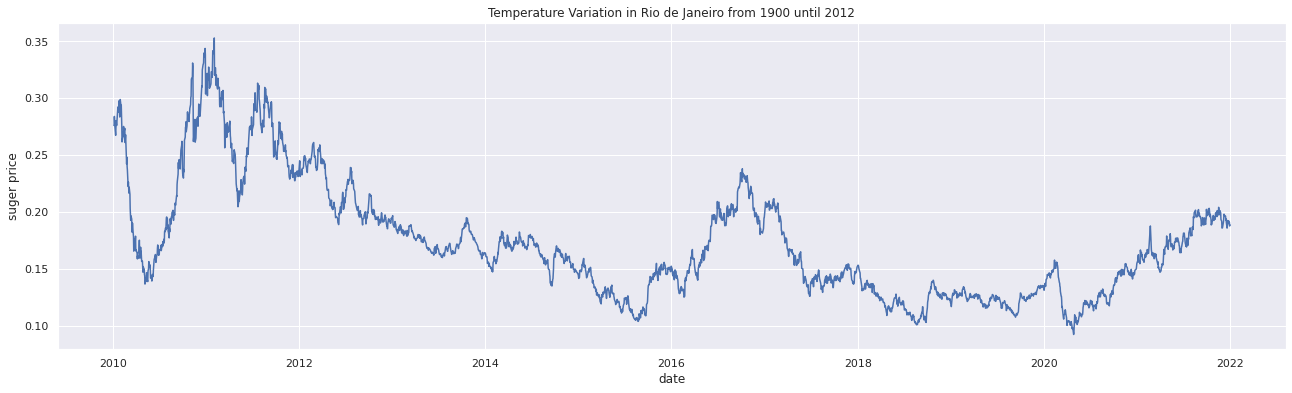

In [5]:
plt.figure(figsize=(22,6))
sns.lineplot(x=df.index, y=df['suger price'])
plt.title('Temperature Variation in Rio de Janeiro from 1900 until 2012')
plt.show()

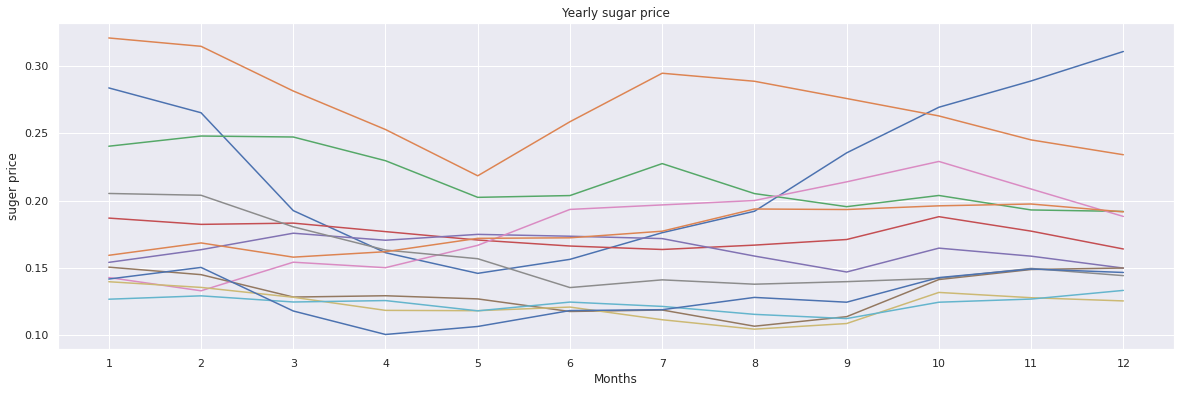

In [6]:
# i'm going to create a pivot table to plot the monthly temperatures through the years
df['month'] = df.index.month
df['year'] = df.index.year
pivot = pd.pivot_table(df, values='suger price', index='month', columns='year', aggfunc='mean')
pivot.plot(figsize=(20,6))
plt.title('Yearly sugar price')
plt.xlabel('Months')
plt.ylabel('suger price')
plt.xticks([x for x in range(1,13)])
plt.legend().remove()
plt.show()

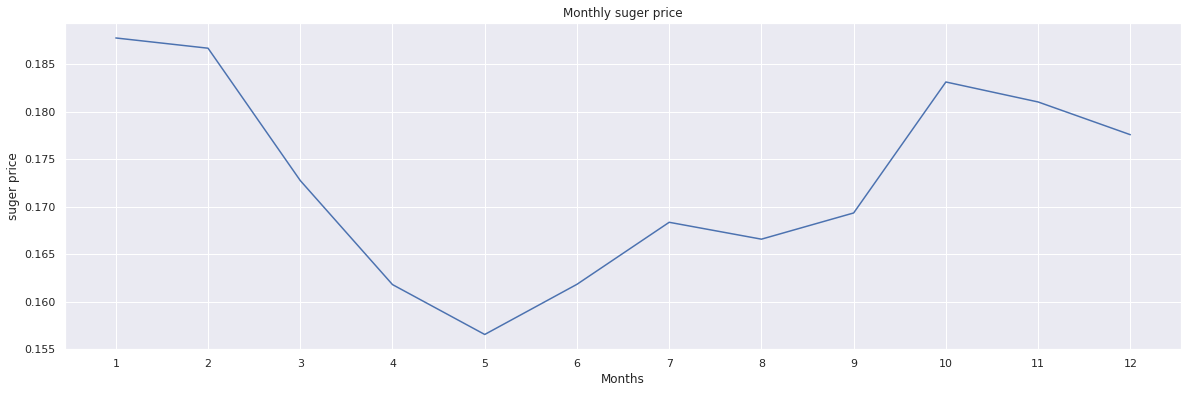

In [7]:
monthly_seasonality = pivot.mean(axis=1)
monthly_seasonality.plot(figsize=(20,6))
plt.title('Monthly suger price')
plt.xlabel('Months')
plt.ylabel('suger price')
plt.xticks([x for x in range(1,13)])
plt.show()

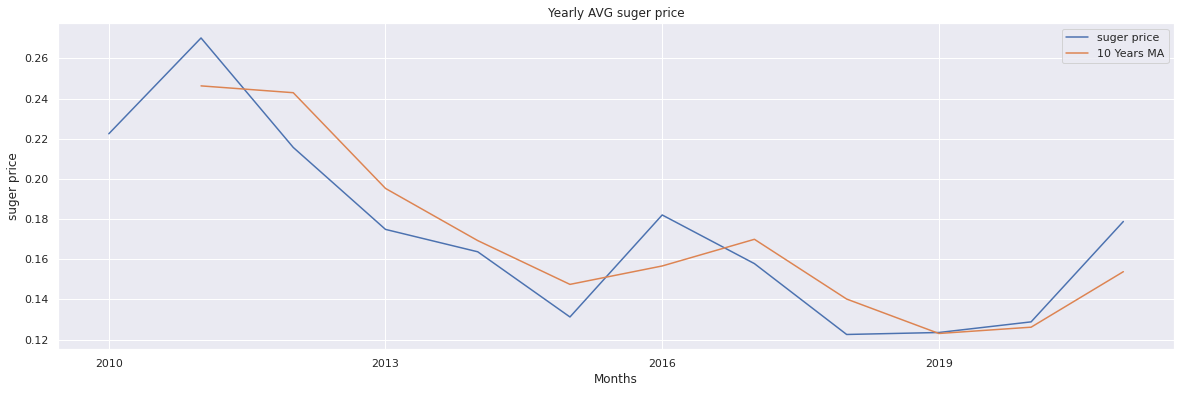

In [8]:
year_avg = pd.pivot_table(df, values='suger price', index='year', aggfunc='mean')
year_avg['10 Years MA'] = year_avg['suger price'].rolling(2).mean()
year_avg[['suger price','10 Years MA']].plot(figsize=(20,6))
plt.title('Yearly AVG suger price')
plt.xlabel('Months')
plt.ylabel('suger price')
plt.xticks([x for x in range(2010,2021,3)])
plt.show()

Overview of the data.
Let's see overview of the data.
We can use seasonal_decompose method to separate into four graphs(Observed,Trend,Seasonal,Residual).
What is seasonal_decompose method parameter 'freq'?

freq = 365 : trend of year.
freq = 30 : trend of month.
freq = 7 : trend of week.
We choose 'freq=365' ,because this data is long term.

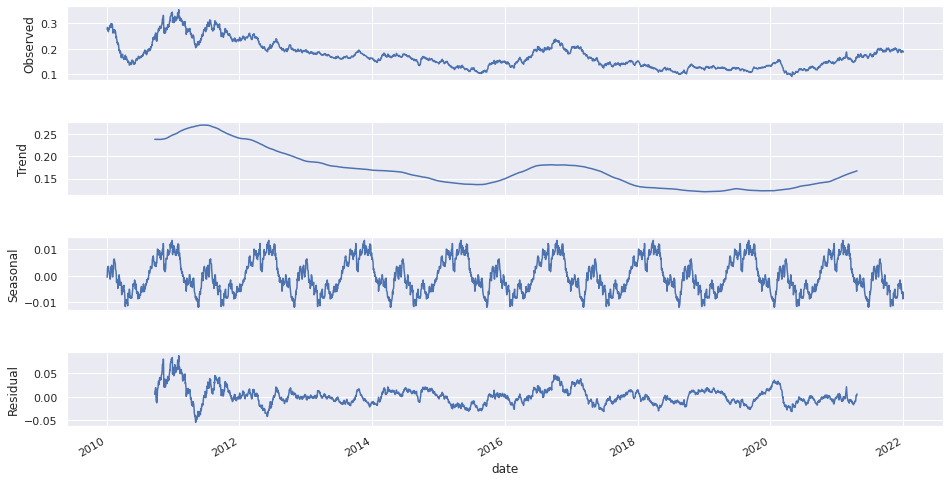

The data has trend in the negative


In [11]:
res = sm.tsa.seasonal_decompose(df['suger price'],freq=365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()
print("The data has trend in the negative")

In [12]:
train = df.loc['2010-01-01' : '2018-12-31'].copy()
val = df.loc['2019-01-01' : '2020-12-31'].copy()
test = df.loc['2021-01-01' : '2021-12-31'].copy()

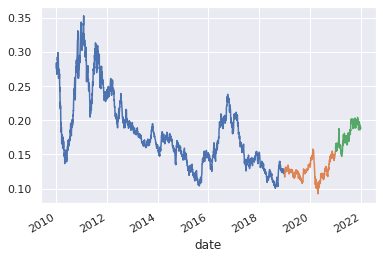

In [13]:
# Create an axis
fig, ax = plt.subplots()

# Plot the train and test sets on the axis ax
train["suger price"].plot(ax=ax)
val["suger price"].plot(ax=ax)
test["suger price"].plot(ax=ax)
plt.show()

In [14]:
# Excluding the first line, as it has NaN values
baseline = val["suger price"].shift()
baseline.dropna(inplace=True)
baseline.head()

date
2019-01-03    0.1193
2019-01-04    0.1169
2019-01-07    0.1193
2019-01-08    0.1265
2019-01-09    0.1276
Name: suger price, dtype: float64

In [15]:
def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true,y_pred))

# Using the function with the baseline values
rmse_base = measure_rmse(val.iloc[1:,0],baseline)
print(f'The RMSE of the baseline that we will try to diminish is {round(rmse_base,4)} celsius degrees')

The RMSE of the baseline that we will try to diminish is 0.0021 celsius degrees


In [16]:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('Rio de Janeiro Temperature Variation')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

In [17]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Results of Dickey-Fuller Test:
Test Statistic                   -2.5520
p-value                           0.1033
Lags Used                        17.0000
Number of Observations Used    2249.0000
Critical Value (1%)              -3.4333
dtype: float64
Test Statistic                   -2.5520
p-value                           0.1033
Lags Used                        17.0000
Number of Observations Used    2249.0000
Critical Value (1%)              -3.4333
Critical Value (5%)              -2.8628
dtype: float64
Test Statistic                   -2.5520
p-value                           0.1033
Lags Used                        17.0000
Number of Observations Used    2249.0000
Critical Value (1%)              -3.4333
Critical Value (5%)              -2.8628
Critical Value (10%)             -2.5675
dtype: float64

The Test Statistics is higher than the Critical Value of 5%.
The serie isn't stationary


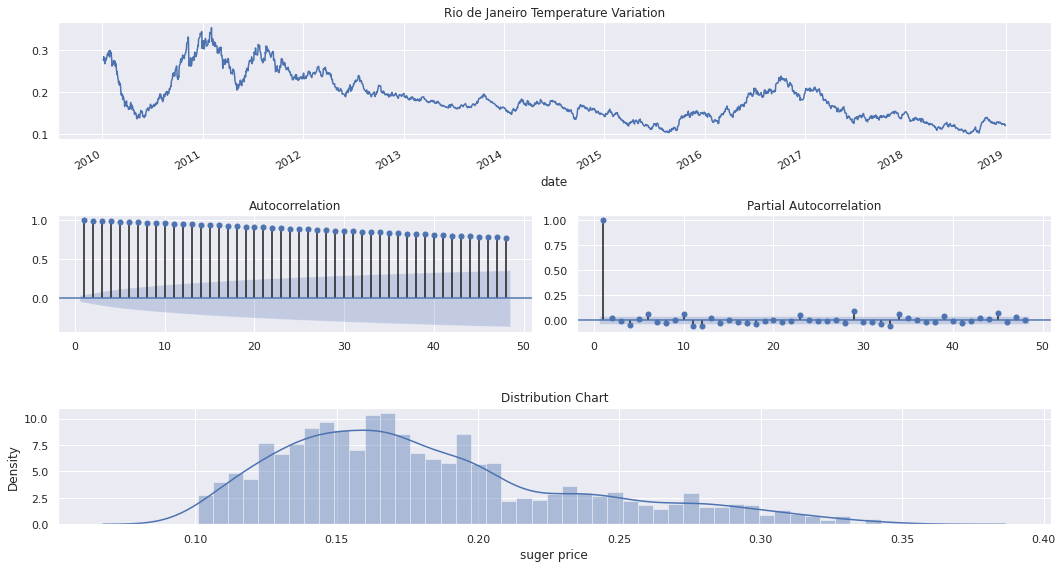

In [18]:
# The first approach is to check the series without any transformation
check_stationarity(train['suger price'])

Results of Dickey-Fuller Test:
Test Statistic                   -8.7134
p-value                           0.0000
Lags Used                        27.0000
Number of Observations Used    2238.0000
Critical Value (1%)              -3.4333
dtype: float64
Test Statistic                   -8.7134
p-value                           0.0000
Lags Used                        27.0000
Number of Observations Used    2238.0000
Critical Value (1%)              -3.4333
Critical Value (5%)              -2.8628
dtype: float64
Test Statistic                   -8.7134
p-value                           0.0000
Lags Used                        27.0000
Number of Observations Used    2238.0000
Critical Value (1%)              -3.4333
Critical Value (5%)              -2.8628
Critical Value (10%)             -2.5675
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


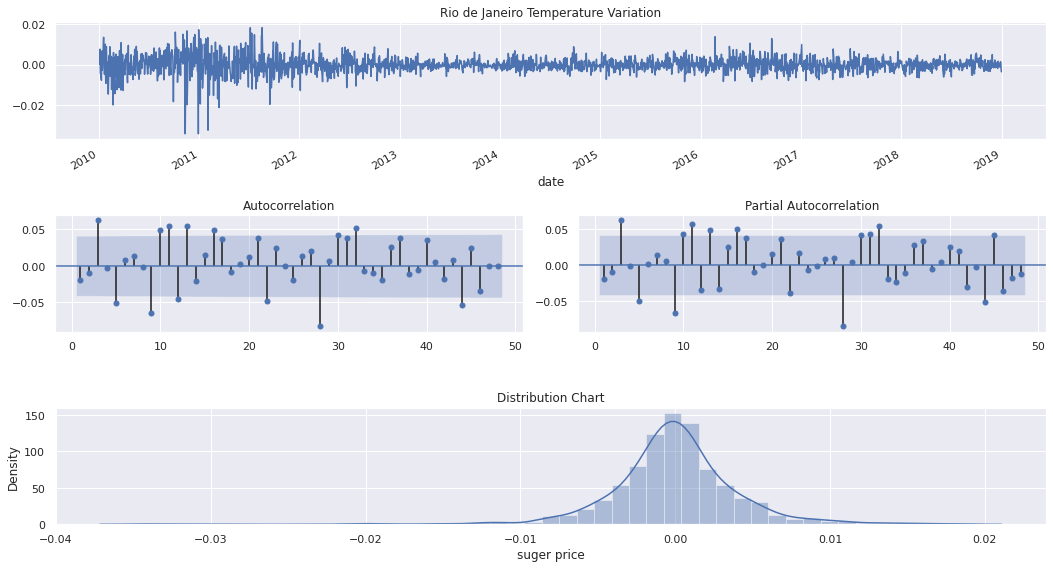

In [19]:
check_stationarity(train['suger price'].diff(1).dropna())

In [20]:
def walk_forward(training_set, validation_set, params):
    '''
    Params: it's a tuple where you put together the following SARIMA parameters: ((pdq), (PDQS), trend)
    '''
    history = [x for x in training_set.values]
    prediction = list()
    
    # Using the SARIMA parameters and fitting the data
    pdq, PDQS, trend = params

    #Forecasting one period ahead in the validation set
    for week in range(len(validation_set)):
        model = sm.tsa.statespace.SARIMAX(history, order=pdq, seasonal_order=PDQS, trend=trend)
        result = model.fit(disp=False)
        yhat = result.predict(start=len(history), end=len(history))
        prediction.append(yhat[0])
        history.append(validation_set[week])
        
    return prediction

In [ ]:
# Let's test it in the validation set
val['Pred'] = walk_forward(train['suger price'], val['suger price'], ((4,1,6),(0,0,0,0),'c'))

In [ ]:
# Measuring the error of the prediction
rmse_pred = measure_rmse(val['suger price'], val['Pred'])

print(f"The RMSE of the SARIMA(4,1,6),(0,0,0,0),'c' model was {round(rmse_pred,4)} celsius degrees")
print(f"It's a decrease of {round((rmse_pred/rmse_base-1)*100,2)}% in the RMSE")

The RMSE of the SARIMA(4,1,6),(0,0,0,0),'c' model was 0.0021 celsius degrees
It's a decrease of 0.69% in the RMSE


In [ ]:
# Creating the error column
val['Error'] = val['suger price'] - val['Pred']

In [ ]:
def plot_error(data, figsize=(20,8)):
    '''
    There must have 3 columns following this order: Temperature, Prediction, Error
    '''
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    #Plotting the Current and Predicted values
    ax1.plot(data.iloc[:,0:2])
    ax1.legend(['Real','Pred'])
    ax1.set_title('Current and Predicted Values')
    
    # Residual vs Predicted values
    ax2.scatter(data.iloc[:,1], data.iloc[:,2])
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Errors')
    ax2.set_title('Errors versus Predicted Values')
    
    ## QQ Plot of the residual
    sm.graphics.qqplot(data.iloc[:,2], line='r', ax=ax3)
    
    # Autocorrelation plot of the residual
    plot_acf(data.iloc[:,2], lags=(len(data.iloc[:,2])-1),zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

In [ ]:
# We need to remove some columns to plot the charts
val.drop(['month','year'], axis=1, inplace=True)
val.head()

,suger price,Pred,Error
date,,,
2019-01-02,0.1193,0.120229,-0.000929
2019-01-03,0.1169,0.119376,-0.002476
2019-01-04,0.1193,0.116659,0.002641
2019-01-07,0.1265,0.119139,0.007361
2019-01-08,0.1276,0.126270,0.001330


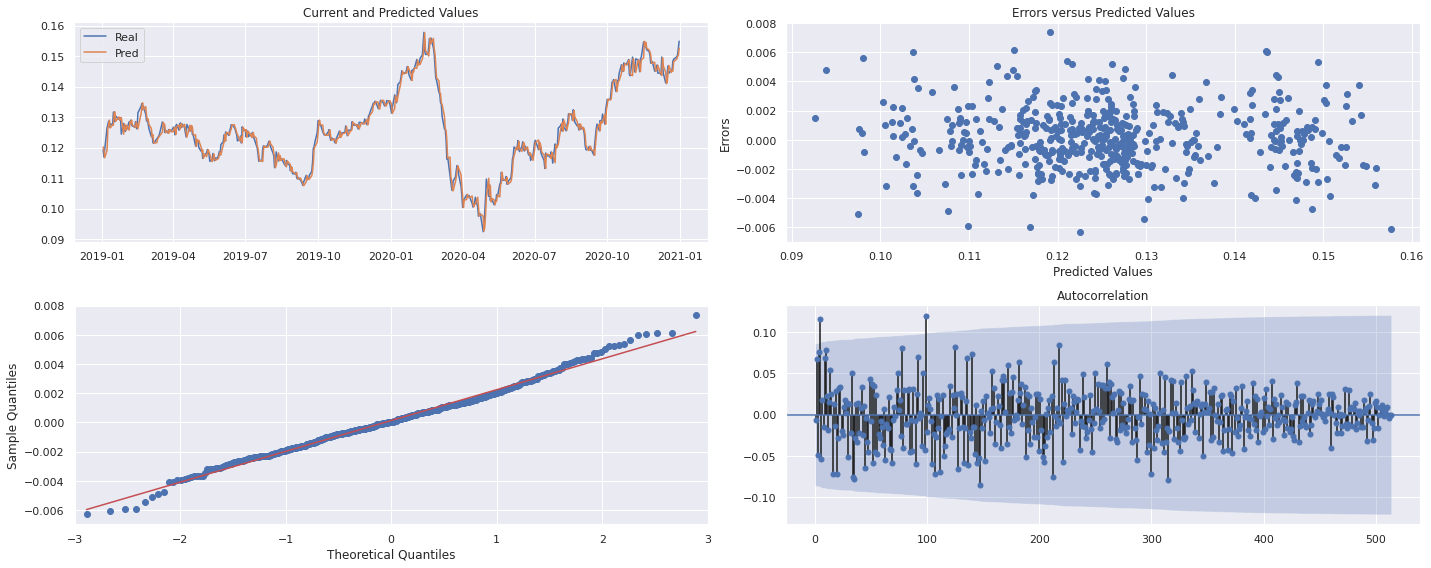

In [ ]:
plot_error(val)

In [ ]:
#Creating the new concatenating the training and validation set:
future = pd.concat([train['suger price'], val['suger price']])
future.head()

date
2010-01-04    0.2762
2010-01-05    0.2764
2010-01-06    0.2841
2010-01-07    0.2800
2010-01-08    0.2753
Name: suger price, dtype: float64

In [ ]:
test.tail()

,suger price,month,year,Pred
date,,,,
2021-12-27,0.1921,12,2021,NaN
2021-12-28,0.1896,12,2021,NaN
2021-12-29,0.1910,12,2021,NaN
2021-12-30,0.1878,12,2021,NaN
2021-12-31,0.1888,12,2021,NaN


In [ ]:
# Using the same parameters of the fitted model
model = sm.tsa.statespace.SARIMAX(future, order=(4,1,6), seasonal_order=(0,0,0,0), trend='c')
result = model.fit(disp=False) 

In [ ]:
test1= result.predict(start=(len(future)), end=(len(future)+365))

In [ ]:
test1[1:]

2782    0.154882
2783    0.154922
2784    0.154767
2785    0.154645
2786    0.154622
          ...   
3142    0.138512
3143    0.138467
3144    0.138422
3145    0.138376
3146    0.138331
Length: 365, dtype: float64

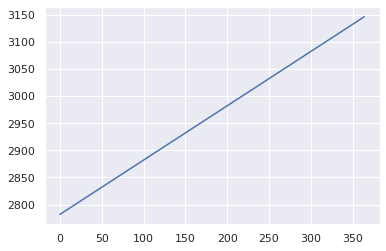

In [ ]:

plt.plot( test1[1:], label='SARIMA')
plt.show()

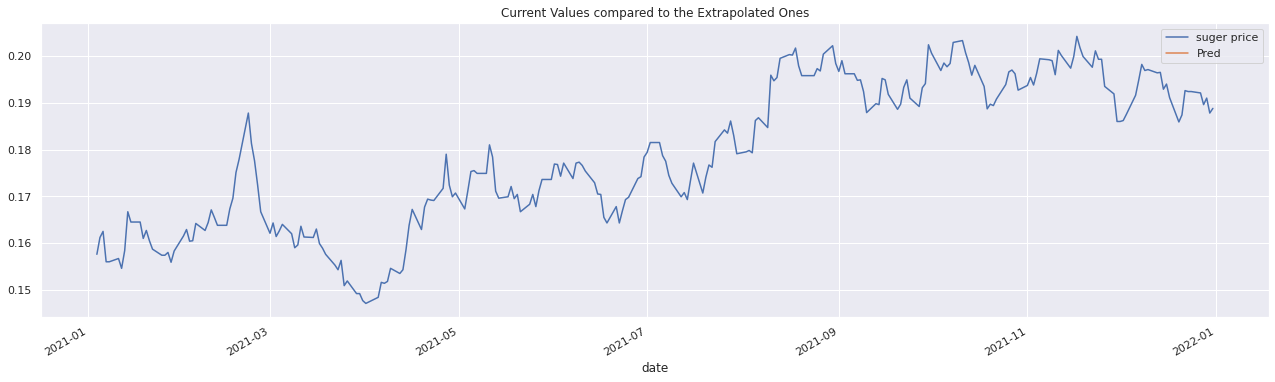

In [ ]:
test[['suger price', 'Pred']].plot(figsize=(22,6))
plt.title('Current Values compared to the Extrapolated Ones')
plt.show()

In [ ]:
df

,suger price,month,year
date,,,
2010-01-04,0.2762,1,2010
2010-01-05,0.2764,1,2010
2010-01-06,0.2841,1,2010
2010-01-07,0.2800,1,2010
2010-01-08,0.2753,1,2010
...,...,...,...
2021-12-27,0.1921,12,2021
2021-12-28,0.1896,12,2021
2021-12-29,0.1910,12,2021


Model choice
each models have parameters.

ARMA model:(p,q)
ARIMA model:(p,d,q)
SARIMA model:(p,d,q)(sp,sd,sq,s)
ARIMAX model:(p,d,q) + exog
SARIMAX model:(p,d,q)(sp,sd,sq,s) +exog

We have to choice a model, After we comfirm that a data has a trend(is stationary) or not.
For example, ARMA model is premised that the data is stationary.

We can use ADF-test to check stationary of the data.

What is adfuller method parameter 'regression'?

’c’ : constant only (default)
’ct’ : constant and trend
’ctt’ : constant, and linear and quadratic trend
’nc’ : no constant, no trend

In [40]:
train = df.loc['2010-01-01' : '2018-12-31']
test = df.loc['2019-01-01' : '2021-12-31']

In [41]:
# Import augmented dicky-fuller test function
from statsmodels.tsa.stattools import adfuller

# Run test
##Originally data
result_c = adfuller(df['suger price'],regression='c')
result_ct = adfuller(df['suger price'],regression='ct')
result_ctt = adfuller(df['suger price'],regression='ctt')
result_nc = adfuller(df['suger price'],regression='nc')
##Diff data
result_Diff_c = adfuller(df['suger price'].diff().dropna(),regression='c')
result_Diff_ct = adfuller(df['suger price'].diff().dropna(),regression='ct')
result_Diff_ctt = adfuller(df['suger price'].diff().dropna(),regression='ctt')
result_Diff_nc = adfuller(df['suger price'].diff().dropna(),regression='nc')



In [42]:
models = pd.DataFrame({
    'ADFtest': [ 'Constant only', 'onstant and trend', 'constant, and linear and quadratic trend', 'no constant no trend',
                'Constant only Diff', 'onstant and trend Diff', 'constant, and linear and quadratic trend Diff', 'no constant no trend Diff'],
    'Pvalue': [result_c[1],result_ct[1],result_ctt[1],result_nc[1],result_Diff_c[1],result_Diff_ct[1],result_Diff_ctt[1],result_Diff_nc[1]]})
models["Decision"]= np.where( models["Pvalue"] > 0.05 , "The H0 of DF test accepted the serie not stationry","The H0 of DF test rejected the serie stationry")
                    

In [43]:
models

,ADFtest,Pvalue,Decision
0,Constant only,7.579056e-02,The H0 of DF test accepted the serie not stati...
1,onstant and trend,2.023568e-01,The H0 of DF test accepted the serie not stati...
2,"constant, and linear and quadratic trend",1.604576e-01,The H0 of DF test accepted the serie not stati...
3,no constant no trend,2.592254e-01,The H0 of DF test accepted the serie not stati...
4,Constant only Diff,7.031335e-18,The H0 of DF test rejected the serie stationry
5,onstant and trend Diff,8.469412e-16,The H0 of DF test rejected the serie stationry
6,"constant, and linear and quadratic trend Diff",1.470103e-15,The H0 of DF test rejected the serie stationry
7,no constant no trend Diff,4.273920e-18,The H0 of DF test rejected the serie stationry


Usually,　We try to testing　both data Original and Diff.
Like the results above, When Original-data is not stationary and Diff-data is stationary,the time series is called unit root process.
For unit root process, We use ARIMA or SARIMA model.

From results,We decided that Original time series is not stational.
We will try to using ARIMA model.

Correlograms
Autocorrelogram & Partail Autocorrelogram is useful that to estimate each models parametaers.

In [ ]:
resDiff = sm.tsa.arma_order_select_ic(train['suger price'], max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (4, 6) is the best.


In [44]:
arima = sm.tsa.statespace.SARIMAX(train['suger price'],order=(4,1,6),seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,)
model = arima.fit(disp=-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:            suger price   No. Observations:                 2267
Model:               SARIMAX(4, 1, 6)   Log Likelihood                9184.629
Date:                Wed, 09 Mar 2022   AIC                         -18347.259
Time:                        10:17:50   BIC                         -18284.309
Sample:                             0   HQIC                        -18324.287
                               - 2267                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7106      0.722     -0.984      0.325      -2.126       0.705
ar.L2         -0.6195      0.424     -1.460      0.144      -1.451       0.212
ar.L3         -0.2581      0.333     -0.775      0.439      -0.911       0.395
ar.L4         -0.2290      0.253     -0.906      0.365      -0.724       0.266
ma.L1          0.6982      0.721      0.968      0.333      -0.715       2.112
ma.L2          0.6143      0.420      1.462      0.144      -0.209       1.438
ma.L3          0.3109      0.330      0.943      0.346      -0.335       0.957
ma.L4          0.2580      0.258      0.999      0.318      -0.248       0.764
ma.L5         -0.0233      0.029     -0.801      0.423      -0.080       0.034
ma.L6         -0.0073      0.040     -0.183      0.855      -0.086       0.071
sigma2      1.718e-05   2.31e-07     74.403      0.000    1.67e-05    1.76e-05
===================================================================================
Ljung-Box (Q):                      104.61   Jarque-Bera (JB):              9230.05
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
arima1 = sm.tsa.statespace.SARIMAX(tra,order=(6,1,2),seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,)
model1 = arima1.fit(disp=-1)
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:            suger price   No. Observations:                 2781
Model:               SARIMAX(6, 1, 2)   Log Likelihood               11484.654
Date:                Tue, 01 Feb 2022   AIC                         -22951.307
Time:                        14:16:29   BIC                         -22897.955
Sample:                             0   HQIC                        -22932.040
                               - 2781                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0095      0.475     -0.020      0.984      -0.941       0.922
ar.L2         -0.0020      0.280     -0.007      0.994      -0.551       0.547
ar.L3          0.0608      0.013      4.778      0.000       0.036       0.086
ar.L4         -0.0003      0.031     -0.011      0.991      -0.061       0.060
ar.L5         -0.0434      0.020     -2.221      0.026      -0.082      -0.005
ar.L6         -0.0012      0.022     -0.053      0.957      -0.045       0.043
ma.L1         -0.0093      0.476     -0.020      0.984      -0.942       0.924
ma.L2          0.0017      0.273      0.006      0.995      -0.533       0.536
sigma2      1.483e-05   1.66e-07     89.581      0.000    1.45e-05    1.52e-05
===================================================================================
Ljung-Box (Q):                      107.64   Jarque-Bera (JB):             14264.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                            -0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'RSS: %.4f')

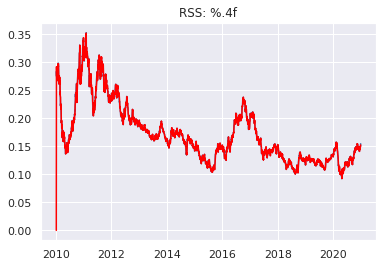

In [ ]:
plt.plot(tra)
plt.plot(model.fittedvalues, color='red')
plt.title('RSS: %.4f')


In [54]:
# Generate predictions and with , dynamic=True
one_step_forecast = model.get_prediction(start=-356)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = one_step_forecast.conf_int()


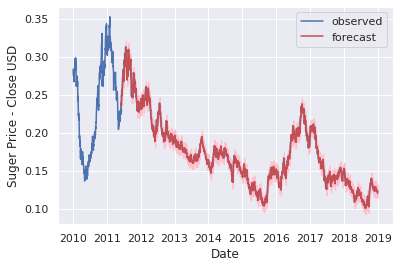

In [55]:
# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower suger price']
upper_limits = confidence_intervals.loc[:,'upper suger price']

plt.plot(train.index, train, label='observed')

# plot your mean forecast
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
         upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Suger Price - Close USD')
plt.legend()
plt.show()

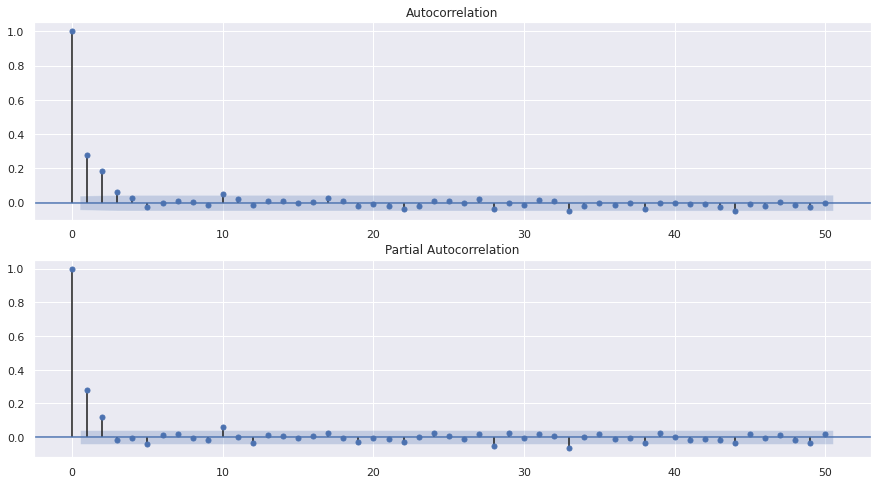

In [48]:
res = model.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [ ]:
tes = DataFrame(test)
test

In [ ]:
train

In [51]:

x =model.forecast(steps=517)


In [52]:
x

2267    0.120248
2268    0.120346
2269    0.120162
2270    0.120115
2271    0.120324
          ...   
2779    0.120241
2780    0.120241
2781    0.120241
2782    0.120241
2783    0.120241
Length: 517, dtype: float64

In [ ]:
tes

date
2020-01-02    0.1313
2020-01-03    0.1331
2020-01-06    0.1373
2020-01-07    0.1359
2020-01-08    0.1347
               ...  
2021-12-27    0.1921
2021-12-28    0.1896
2021-12-29    0.1910
2021-12-30    0.1878
2021-12-31    0.1888
Name: suger price, Length: 517, dtype: float64

In [ ]:
test_pres = pd.concat([tes, x])

In [ ]:
test_pres
X = pd.DataFrame(x, columns=list('c'))
X.rename(columns={'c':'Forcast'}, inplace=True)
X

2020-01-02 00:00:00    0.131300
2020-01-03 00:00:00    0.133100
2020-01-06 00:00:00    0.137300
2020-01-07 00:00:00    0.135900
2020-01-08 00:00:00    0.134700
                         ...   
3293                   0.154869
3294                   0.154869
3295                   0.154869
3296                   0.154869
3297                   0.154869
Length: 1034, dtype: float64

In [ ]:
test['pridect']=model.predict(start=1,end=700, dynamic=True)
test[['suger price','pridect']].plot(figsize=(20, 5))

In [61]:
y_forecasted = one_step_forecast.predicted_mean
y_truth = test['suger price'].squeeze()
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse,5)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse),10)))

The Mean Squared Error is nan
The Root Mean Squared Error is nan


In [59]:
f= test['pridect']
f

date
2019-01-02   NaN
2019-01-03   NaN
2019-01-04   NaN
2019-01-07   NaN
2019-01-08   NaN
              ..
2021-12-27   NaN
2021-12-28   NaN
2021-12-29   NaN
2021-12-30   NaN
2021-12-31   NaN
Name: pridect, Length: 773, dtype: float64

In [23]:
import datetime
from dateutil.relativedelta import relativedelta
start = datetime.datetime.strptime("2022-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future_prediction = pd.DataFrame(index=date_list, columns= data.columns)
data = pd.concat([data, future])

NameError: ignored